[Хабр](https://habrahabr.ru/company/ods/blog/325422/)

* feature extraction, feature engineering -- извлечение признаков, отражающих полезную для модели информацию, из знаний прикладной области и сырых данных
* feature transformation -- повышение удобства данных для модели
* feature selection -- выбор наиболее полезных признаков

# Feature extraction

## Текст
* Токенизация -- в слова / в n-граммы
* Приведение к нормальной форме -- стеммизация / леммизация (см. [Link](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html))
* Хранение в векторах
  * Bag of words -- сильно разреженное пространство слов, простейший вариант. О чем позаботиться: стоп-слова, размер словаря, эффективность хранения и работы. Теряем информацию о порядке слов
  * n-gramms
  * Bag of words + [tf-idf](https://en.wikipedia.org/wiki/Tf–idf)
  * Word2vec -- векторизация в пространство размерности порядка сотен с возможностью вычисления семантической близости между векторами. Нужно очень много данных, есть предобученные модели ([Link](https://github.com/3Top/word2vec-api#where-to-get-a-pretrained-models))
  
### Tf-idf
* $tf(t, d)$ -- term frequency -- частота терма в документе, каким-то образом нормированная или сглаженная
* $idf(t, D) = \log \frac {\mid D \mid} {df(d,t) + 1}$ -- inversed document frequency -- один из вариантов
* $tfidf(t, d, D) = tf(t, d) \times idf(t, D)$
* получаем характеристику частоты терма в документе относительно его частоты в корпусе


## Изображения
* до нейросетей было очень сложно, например, каскады Хаара
* сейчас -- сверточные сети, есть куча предобученных
* для конкретных данных нужно проводить fine-tuning -- заменить последние полносвязные слои на свои, подобранные под конкретную задачу, сеть дообучается
* для векторизации можно просто оторвать последние слои
* простые фичи (яркость изображения, мета-информация) можно и своими руками

## Геоданные
геокодоинг -- по адресу найти координаты, обратный геокодинг

## Дата-время
* дни недели, выходные, отдельные праздники
* время: не корректная упорядоченность, близость -- можно спроецировать на окружность и рассматривать синусы-косинусы

## Веб
* User Agent: ось, браузер, is_mobile
* хитрые признаки, например "отставание версии браузера"
* реферер, предпочтительный язык, другие специфические фичи

# Feature transformation

## Нормализация и изменение распределения
* нормальность распределения важна для многих моделей
* логарифм уберет слишком большие значения
* нормализация критична, например, для ближайших соседей
    * StandartScaler: $z = \frac{x – \mu}{\sigma}$ -- не совсем нормальное, но от выбросов защитит
    * MinMaxScaler -- всё на (0, 1)
    * оба стандартные, первый необходим для расстояния, второй удобен для визуализации
* проверка нормальности распределения
    * `from scipy.stats import shapiro` -- вернет значение статистики и p-value (нулевая гипотеза -- данные нормальны, p-value -- "вероятность, что такое набралось из нормального распределения)
    * QQ-plot: для нормального диагональ
* логнормальное распределение -- для зарплат, населения городов, стоимости акций, количества комментариев



In [33]:
import numpy as np
from sklearn.preprocessing import StandardScaler  
from scipy.stats import shapiro, beta, norm, lognorm


data_beta = beta(1, 10).rvs(1000).reshape(-1, 1)

print("Beta:", shapiro(data_beta))     # значение статистики, p-value 

print("Beta with StandartScaler:", shapiro(StandardScaler().fit_transform(data_beta)))
# с таким p-value придется отклонять нулевую гипотезу о нормальности данных

data_norm = norm().rvs(5000).reshape(-1, 1)
print("Normal data:", shapiro(data_norm))
# данные явно нормальны


data_lognorm = lognorm(s=1).rvs(1000).reshape(-1, 1)
print("Lognorm data:", shapiro(data_lognorm))

print("Lognorm data + log:", shapiro(np.log(data_lognorm)))

Beta: (0.8704356551170349, 5.4995902156599435e-28)
Beta with StandartScaler: (0.8704356551170349, 5.4995902156599435e-28)
Normal data: (0.9994956254959106, 0.2062387317419052)
Lognorm data: (0.5959844589233398, 3.825544807606751e-43)
Lognorm data + log: (0.9993285536766052, 0.9833261370658875)


''

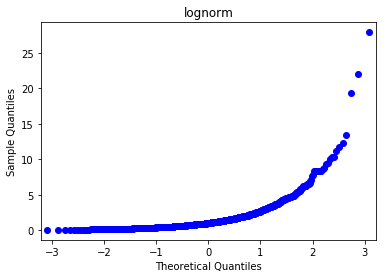

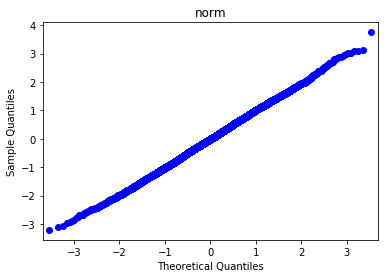

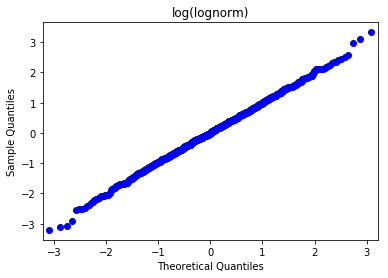

In [43]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

sm.qqplot(data_lognorm.reshape(1, -1)[0])
plt.title('lognorm')
sm.qqplot(data_norm.reshape(1, -1)[0])
plt.title('norm')
sm.qqplot(np.log(data_lognorm).reshape(1, -1)[0])
plt.title('log(lognorm)')
""

## Interactions (взаимодействия)
Можно вычислить различные отношения между фичами, если их не слишком много

Пример: полиномиальная регрессия. [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

## Заполнение пропусков
* отдельное пустое значение
* самое вероятное значение (среднее / медиана / мода)
* невероятное значение (позволит деревьям отделять пропуски от реальных данных)
* для упорядоченных по времени данных можно взять соседнее значение
* [pandas.DataFrame.fillna](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) и [sklearn.preprocessing.Imputer](http://scikit-learn.org/stable/modules/preprocessing.html#imputation)

# Выбор признаков (features selection)
Уменьшает вычислительную сложность, избавляет от шума в бесполезных признаках, который модель может принять за полезный сигнал.

## Статистические методы
* на основе низкой вариации (sklearn.feature_selection.VarianceThreshold)
* другие ([Link](http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection))
    * SelectKBest, SelectPercentile -- оставляет нужное количество / процент фич, лучших по некоторой scoring function 
    * f_regression, mutual_info_regression для регрессии, chi2, f_classif, mutual_info_classif для классификации

## Отбор с использованием модели
* даем простому лесу либо линейной регрессии с lasso данные, смотрим, какие не пригодились
* исходим из гипотезы, что раз простой модели фичи не нужны, то сложной и подавно
* но может сделать хуже

## Перебор
* [Exhaustive Feature Selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/) -- перебираем все возможные комбинации признаков -- очень долго
* [Sequential Feature Selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/) -- находим N оптимальных, постепенно добавляем по одному
